# Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
import pycountry
import pycountry_convert as pc
from matplotlib.lines import Line2D
from geopy.geocoders import Nominatim
import requests

In [2]:
pd.options.mode.chained_assignment = None

# Load the Data

In [3]:
merged_df = pd.read_csv("merged_df_1.csv", sep=",", encoding = "ISO-8859-1")

In [4]:
merged_df.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_date,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-qounter,:qounter,http://www.qounter.com,application platforms|real time|social network...,Operating,USA,DE,De - Other,Delaware City,2014-04-09,/funding-round/22dacff496eb7acb2b901dec1dfe5633,Venture,A,2014-10-14,NaN
1,/organization/-qounter,:qounter,http://www.qounter.com,application platforms|real time|social network...,Operating,USA,DE,De - Other,Delaware City,2014-04-09,/funding-round/b44fbb94153f6cdef13083530bb48030,Seed,NaN,2014-01-03,700000.0
2,/organization/0-6-com,0-6.com,http://www.0-6.com,curated web,Operating,CHN,22,Beijing,Beijing,2007-01-01,/funding-round/5727accaeaa57461bd22a9bdd945382d,Venture,A,2008-03-19,2000000.0
3,/organization/004-technologies,004 technologies,http://004gmbh.de/en/004-interact,software,Operating,USA,IL,"Springfield, Illinois",Champaign,2010-01-01,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,Venture,NaN,2014-07-24,NaN
4,/organization/0ndine-biomedical-inc,ondine biomedical inc.,http://ondinebio.com,biotechnology,Operating,CAN,BC,Vancouver,Vancouver,1997-01-01,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,Seed,NaN,2009-11-09,43360.0


# Data Exploration and Cleaning

In [5]:
# Check how many unique companies appear in the merged dataset
merged_df['permalink'].describe()

count                        94415
unique                       51136
top       /organization/solarflare
freq                            19
Name: permalink, dtype: object

In [6]:
# Get some more information on the dataframe
merged_df.columns

Index(['permalink', 'name', 'homepage_url', 'category_list', 'status',
       'country_code', 'state_code', 'region', 'city', 'founded_date',
       'funding_round_permalink', 'funding_round_type', 'funding_round_code',
       'funded_at', 'raised_amount_usd'],
      dtype='object')

## Dealing with Missing Data

Start by visualising the missing values. You can see that the missing values are generally in the same row for country_code, state_code, region and city, which means that by removing rows with null values for one variable will remove most of the null values from the others. 

funding_round_code has quite a few missing values, and was deleted. However, it was used again later on in this code after attempting to build a model which didn't perform well. 

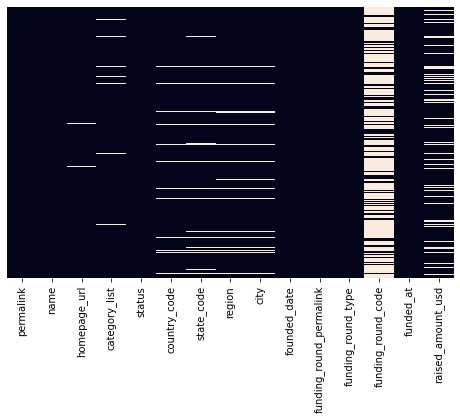

In [7]:
# Visualise NaN values
plt.figure(figsize=(8,5))
sns.heatmap(merged_df.isnull(), cbar=False, yticklabels=False)
plt.show()

In [8]:
# Show the % of missing values out of all values in the df
round(100*(merged_df.isnull().sum()/len(merged_df.index)), 2)

permalink                   0.00
name                        0.00
homepage_url                3.63
category_list               1.67
status                      0.00
country_code                5.25
state_code                  7.00
region                      6.22
city                        6.22
founded_date                0.00
funding_round_permalink     0.00
funding_round_type          0.00
funding_round_code         72.53
funded_at                   0.00
raised_amount_usd          16.34
dtype: float64

#### Insights
- There are a lot of missing values in **funding_round_code**, but this is too many to remove every row containing an NaN value. It would be better to remove the whole column than all the rows. 
- **raised_amount_usd** is also missing a fair few values. This could be split later into a set that could be used for model implementation. Alternatively, the NaN values are likely just not disclosed so could be estimated based on the average funding amount for that company or for companies in the same region.
- **homepage_url** is missing some values but this will be removed anyway
- **city** and **region** are missing a similar number of values. This could be because if a company enters one they will likely enter both. As they are similar values, region will be removed and city kept. **state_code** is a similar entry to this will be removed too.

Remove the columns that are not needed and see how this affects the % of null values now. 

In [9]:
# Remove columns that aren't needed
merged_df = merged_df.drop(columns=['funding_round_code', 'region', 'state_code', 'homepage_url'])

# View the new % of missing values
round(100*(merged_df.isnull().sum()/len(merged_df.index)), 2)

permalink                   0.00
name                        0.00
category_list               1.67
status                      0.00
country_code                5.25
city                        6.22
founded_date                0.00
funding_round_permalink     0.00
funding_round_type          0.00
funded_at                   0.00
raised_amount_usd          16.34
dtype: float64

Removing the columns above didn't affect the % of other null values so these will have to be dealt with too. 

**category_list**, **city** and **country_code** are missing a small number of values, so the NaN values here will be removed. A

s we're trying to predice **raised_amount_usd** later on, it won't be helpful to have NaN values here as we won't be able to measure performance, so these will be removed. 

In [10]:
# Remove rows with null values
merged_df = merged_df[~pd.isnull(merged_df['country_code'])]
merged_df = merged_df[~pd.isnull(merged_df['category_list'])]
merged_df = merged_df[~pd.isnull(merged_df['raised_amount_usd'])]

In [11]:
# Double check how many NaN values are left
round(100*(merged_df.isnull().sum()/len(merged_df.index)), 2)

permalink                  0.00
name                       0.00
category_list              0.00
status                     0.00
country_code               0.00
city                       0.98
founded_date               0.00
funding_round_permalink    0.00
funding_round_type         0.00
funded_at                  0.00
raised_amount_usd          0.00
dtype: float64

There are less than 1% NaN values remaining in the **city** column. 

As it is likely this won't have a massive effect on the final result and it won't be used in model building, they can be filled in with the Country name instead, once the country_code has been used to find the continent and been converted to the name.

## Add New Feature Columns

### 1. Continent

This is for helping visualisations later and will be used in the model.

A function was built to convert the **country_code** to **country_name** and then use ***pycountry*** module to get the continent name. 

Some country codes couldn't be converted, so these were added to a list to check why. It was mostly because mistakes had been made in the conversion and for Romania, the country code had actually been changed to that which used to be Uruguay. 

In [12]:
# Function to create a column with continent from the country code, and replace country code with country name
def convert_to_continent(df,f):
    try:
        alpha2 = pycountry.countries.get(alpha_3=df['country_code']).alpha_2
        df['country_name'] = pycountry.countries.get(alpha_3=df['country_code']).name
        df['continent'] = pc.country_alpha2_to_continent_code(alpha2)
        return df
    except AttributeError:
        f.append(df['country_code'])
        df['continent'] = np.nan
        df['country_name'] = np.nan
        return df

failed = []
merged_df = merged_df.apply(lambda x: convert_to_continent(x, failed), axis=1)

In [13]:
# Find unique country codes that failed to find a match
failed = set(failed)

# Find the rows in the df which correspond to these codes, and therefore the 
merged_df[merged_df['country_code'].isin(list(failed))]

,category_list,city,continent,country_code,country_name,founded_date,funded_at,funding_round_permalink,funding_round_type,name,permalink,raised_amount_usd,status
85,e-commerce|saas,Timisoara,NaN,ROM,NaN,2008-01-01,2015-06-16,/funding-round/af7382f8e3d806986796029388cb1b7f,Venture,123contactform,/organization/123contactform,1000000.0,Operating
540,cloud computing|messaging|telephony|unifed com...,Bucharest,NaN,ROM,NaN,2002-02-18,2010-08-06,/funding-round/299fcb24fab3117ce5e9f8dd4de6b8c2,Undisclosed,4psa,/organization/4psa,5000000.0,Operating
541,cloud computing|messaging|telephony|unifed com...,Bucharest,NaN,ROM,NaN,2002-02-18,2004-01-03,/funding-round/527944de76ea6ee2c1087c2c4e97e078,Angel,4psa,/organization/4psa,1500000.0,Operating
1239,advertising|brand marketing|design|web design|...,Iasi,NaN,ROM,NaN,2008-08-22,2010-01-26,/funding-round/76ecec6de7b22e6b90f35fb77c0bc704,Venture,access point,/organization/access-point,4500000.0,Operating
8265,advertising|search,Nassau,NaN,BAH,NaN,2009-01-04,2008-01-01,/funding-round/bb602d3a0c60214951e651d56433d17b,Seed,bahamaslocal.com,/organization/bahamaslocal-com,1200000.0,Operating
10327,software,Bucharest,NaN,ROM,NaN,2001-01-01,2007-06-12,/funding-round/c53718a6021328642d77c4d93037e96a,Venture,bitdefender,/organization/bitdefender,7000000.0,Operating
10788,curated web|paas|saas|social media|software,Iasi,NaN,ROM,NaN,2014-01-01,2013-01-01,/funding-round/558ff34a66e72ed49d462363e2da720d,Seed,blogvio,/organization/blogvio,70000.0,Operating
10989,security,NaN,NaN,TAN,NaN,2004-01-01,2005-04-04,/funding-round/cc948b5d19a78df98e12b2334e3d0bf2,Angel,blue security,/organization/blue-security,3000000.0,Operating
22312,web design|web development|web hosting,Targu Jiu,NaN,ROM,NaN,2013-08-13,2014-01-11,/funding-round/a6e97b6c7f7d1b77cd0e19e9a7bbea99,Seed,designface it,/organization/designface-it,3766.0,Operating
22313,web design|web development|web hosting,Targu Jiu,NaN,ROM,NaN,2013-08-13,2014-02-17,/funding-round/c65cb3f2a5d9190e869336cc49b4a38b,Equity_Crowdfunding,designface it,/organization/designface-it,3800.0,Operating


In [14]:
merged_df[merged_df['country_code'].isin(list(failed))]['country_code'].value_counts()

ROM    36
TAN    11
BAH     2
Name: country_code, dtype: int64

Updated country codes:

- **ROU** is actually the code for Romania now, but was previously assigned to Uruguay.

- **TAN** is supposed to be Tanzania based on the City it corresponds to. This should be TZA.

- **BAH** is the Bahamas, based on the corresponding city Freeport. This should be BHS. 

These were then replaced and the continent names mapped to the continent codes. 

In [15]:
# Replace incorrect country codes
merged_df['country_code'] = merged_df['country_code'].replace({'ROM':'ROU', 'TAN':'TZA', 'BAH':'BHS'})

# Run these country codes back through the function above
merged_df = merged_df.apply(lambda x: convert_to_continent(x, failed), axis=1)

In [16]:
# Map the continent code to the actual continent using a dictionary with the codes
continents = {
    'NA': 'North America',
    'SA': 'South America',
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

merged_df['continent'] = merged_df['continent'].map(continents)

The majority of entries are from the US, followed by Europe and Asia. There are much fewer from South America, Australia and Africa. 

Now that country_code had been converted to country_name, the missing city names were replaced with the country name. 

In [17]:
# How many entries are there from each continent
merged_df['continent'].value_counts()

North America    55455
Europe           11718
Asia              5931
South America     1174
Australia          660
Africa             220
Name: continent, dtype: int64

In [18]:
# Replace NaN values in 'city' with 'country_name'
merged_df['city'] = merged_df['city'].fillna(merged_df['country_name'])

# Double check NaN values
round(100*(merged_df.isnull().sum()/len(merged_df.index)), 2)

category_list              0.0
city                       0.0
continent                  0.0
country_code               0.0
country_name               0.0
founded_date               0.0
funded_at                  0.0
funding_round_permalink    0.0
funding_round_type         0.0
name                       0.0
permalink                  0.0
raised_amount_usd          0.0
status                     0.0
dtype: float64

In [19]:
# Drop country_code now that it isn't needed
merged_df = merged_df.drop(columns=['country_code'])

### 2. Find Time in months between Founded and Funded

This was to see if there was a pattern between how long it was left between funding rounds and when it was founded. I.e. is it easier to get more investment when you've just launched and are new and exciting, or do you get more when you've been running for a long time and investors have more confidence in you?

In [20]:
# Convert to datetime
merged_df['funded_at'] = pd.to_datetime(merged_df['funded_at'])
merged_df['founded_date'] = pd.to_datetime(merged_df['founded_date'])

# Calculate the number of months since the company was founded
merged_df['time_since_founded'] = ((merged_df['funded_at'] - merged_df['founded_date'])/
                                   np.timedelta64(1, 'M')).astype(int)

In [21]:
merged_df['time_since_founded'].describe()

count    75158.000000
mean        56.266692
std        102.525325
min       -167.000000
25%         12.000000
50%         33.000000
75%         70.000000
max       3057.000000
Name: time_since_founded, dtype: float64

There are some negative times between date founded and the funding round date. This means it was funded before it was founded.

This could be because of a mistake or because the seed/angel/grant funding rounds (most likely) happened before the company was officially founded. 

Therefore, the spread of the data was plotted as below. It looks like there are some outliers here as there's just one peak at around zero, so we need to dig into the data more. 

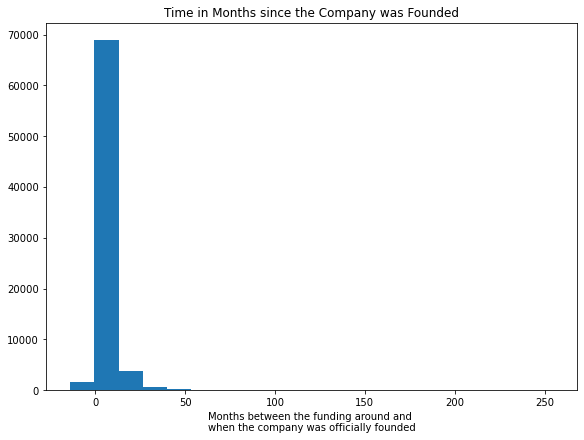

In [22]:
# Plot the time since founded to see the spread of data
time_df = merged_df['time_since_founded']

fig, ax = plt.subplots(figsize=(8,6), constrained_layout = True)
n_bins = 20
ax.hist(time_df/12, bins=n_bins)
ax.set_xlabel('Months between the funding around and \nwhen the company was officially founded')
ax.set_title('Time in Months since the Company was Founded', fontsize=12)

plt.show()

In [23]:
merged_df['funding_round_type'][merged_df['time_since_founded'] < 0].value_counts()

Seed                     1388
Venture                   530
Angel                     350
Grant                     125
Equity_Crowdfunding        65
Debt_Financing             52
Undisclosed                39
Convertible_Note           37
Private_Equity             19
Product_Crowdfunding       13
Non_Equity_Assistance       6
Post_Ipo_Equity             1
Secondary_Market            1
Name: funding_round_type, dtype: int64

### 3. Find number of investment rounds prior to current round, and amount raised

The number of funding rounds and amount raised before the current round is likely to have an impact on the amount raised now. 

It is likely that the more investment rounds the company has been through (up to a limit), the more it's likely to raise. Equally, the more confidence investors will have as they know the company has lasted at least this long. 

In [24]:
# Add a column that creates a column of ones
merged_df['funding_round_number'] = 1

# Create a new dataframe with company permalink, investment round permalink and the cumulative sum of investments
df = merged_df[['permalink', 'funding_round_permalink', 'funded_at', 'funding_round_number', 
                'raised_amount_usd']].sort_values(by='funded_at').groupby(
    ['permalink', 'funding_round_permalink']).sum().groupby(level=0).cumsum()

merged_df = merged_df.drop(columns='funding_round_number')

In [25]:
df.head(10)

funding_round_number  \
permalink                           funding_round_permalink                                                 
/organization/-qounter              /funding-round/b44fbb94153f6cdef13083530bb48030                     1   
/organization/0-6-com               /funding-round/5727accaeaa57461bd22a9bdd945382d                     1   
/organization/0ndine-biomedical-inc /funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d                     1   
                                    /funding-round/954b9499724b946ad8c396a57a5f3b72                     2   
/organization/0xdata                /funding-round/383a9bd2c04f7038bb543ccef5ba3eae                     1   
                                    /funding-round/3bb2ee4a2d89251a10aaa735b1180e44                     2   
                                    /funding-round/ae2a174c06517c2394aed45006322a7e                     3   
                                    /funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e                     4   
/organization/1                     /funding-round/03b975068632eba5bfdb937ec8c07a68                     1   
                                    /funding-round/e82464f22241715dd1a6c77241055ed1                     2   

                                                                                     raised_amount_usd  
permalink                           funding_round_permalink                                             
/organization/-qounter              /funding-round/b44fbb94153f6cdef13083530bb48030           700000.0  
/organization/0-6-com               /funding-round/5727accaeaa57461bd22a9bdd945382d          2000000.0  
/organization/0ndine-biomedical-inc /funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d            43360.0  
                                    /funding-round/954b9499724b946ad8c396a57a5f3b72           762851.0  
/organization/0xdata                /funding-round/383a9bd2c04f7038bb543ccef5ba3eae          3000000.0  
                                    /funding-round/3bb2ee4a2d89251a10aaa735b1180e44         23000000.0  
                                    /funding-round/ae2a174c06517c2394aed45006322a7e         24700000.0  
                                    /funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e         33600000.0  
/organization/1                     /funding-round/03b975068632eba5bfdb937ec8c07a68           150000.0  
                                    /funding-round/e82464f22241715dd1a6c77241055ed1          1150050.0

In [26]:
# remove the current round investment from the cumulative to get amount raised before this round
df = df.rename(columns={'raised_amount_usd': 'amount_raised_to_date'})
df = pd.merge(df, merged_df[['funding_round_permalink', 'raised_amount_usd']], on='funding_round_permalink', 
              how='left')
df['amount_raised_to_date'] = df['amount_raised_to_date'] - df['raised_amount_usd']
df = df.drop(columns='raised_amount_usd')

# Merge investment round by permalink as the key
merged_df = pd.merge(merged_df, df[['funding_round_permalink', 'funding_round_number', 'amount_raised_to_date']], 
                      on='funding_round_permalink', how='left')

### 4. Creating Longitude and Latitude Columns

This was an extra step added after building the first model. Originally the only location feature was the continent. However, this is quite general and almost too simple, especially considering most companies are based in the USA.

The longtitude and latitude were calculated so there would be additional continuous variables to compare to the amount raised, which are much more precise than continent.

The coordinates were found using the city and country name. 

In [27]:
# Function to map country name to longitude and latitude
geolocator = Nominatim(user_agent='your unique UA')

def geolocate(country):
    try:
        loc = geolocator.geocode(country)
        return [loc.latitude, loc.longitude]
    except:
        return np.nan

In [28]:
# Combine city and country to one column 
location_df = merged_df[['city', 'country_name']]
location_df['location'] = location_df['country_name']
location_df.loc[:, 'location'] = location_df[location_df['city'] != location_df['country_name']][['city', 'country_name']].agg(', '.join, axis=1)
location_df = location_df.drop_duplicates()

In [32]:
# Get coordinates from location name
location_df['coordinates'] = location_df['location'].apply(lambda x: geolocate(x))

In [ ]:
location_df['latitude'] = location_df['coordinates'].str[0]
location_df['longitude'] = location_df['coordinates'].str[1]

In [55]:
location_df

,city,country_name,location,coordinates,latitude,longitude
0,Delaware City,United States,"Delaware City, United States","[39.5778901, -75.588815]",39.577890,-75.588815
1,Beijing,China,"Beijing, China","[39.906217, 116.3912757]",39.906217,116.391276
2,Vancouver,Canada,"Vancouver, Canada","[49.2608724, -123.113952]",49.260872,-123.113952
4,Mountain View,United States,"Mountain View, United States","[37.3893889, -122.0832101]",37.389389,-122.083210
8,San Francisco,United States,"San Francisco, United States","[37.7790262, -122.419906]",37.779026,-122.419906
...,...,...,...,...,...,...
75068,Pyrmont,Australia,"Pyrmont, Australia","[-33.8692145, 151.1923633]",-33.869214,151.192363
75084,Grand Blanc,United States,"Grand Blanc, United States","[42.9275277, -83.6299518]",42.927528,-83.629952
75145,Damansara New Village,Malaysia,"Damansara New Village, Malaysia",NaN,NaN,NaN
75149,Gerasdorf Bei Wien,Austria,"Gerasdorf Bei Wien, Austria","[48.31277505, 16.475502981863052]",48.312775,16.475503


In [29]:
# Save the df to a csv file
# location_df.to_csv("location_df_2.csv", sep=',', index=False)

# Load location_df.csv
location_df = pd.read_csv("location_df_2.csv", sep=',', encoding = "ISO-8859-1")

Many of the locations didn't find a match, which was because they had been converted incorrectly when the file was originally imported.
- Countries with NaN values were listed
- They were all smaller countries where taking the coordinates of the centre of the company would not make a small difference
- If they had been in the USA it would have been a bigger assumption to pick the centre

The coordinates were then found by finding the coordinates of the centre of the country they are in. 

In [30]:
# Find any values which didn't work
location_df[location_df['latitude'].isna()].head()

,city,country_name,location,coordinates,latitude,longitude
51,FerriÃÂ£ÃÂ¨Res,Belgium,"FerriÃÂ£ÃÂ¨Res, Belgium",NaN,NaN,NaN
107,Cesson-SÃÂ£ÃÂ©VignÃÂ£ÃÂ©,France,"Cesson-SÃÂ£ÃÂ©VignÃÂ£ÃÂ©, France",NaN,NaN,NaN
148,SÃÂ£ÃÂ£O Paulo,Brazil,"SÃÂ£ÃÂ£O Paulo, Brazil",NaN,NaN,NaN
156,Seoul,"Korea, Republic of","Seoul, Korea, Republic of",NaN,NaN,NaN
174,Southern Md Facility,United States,"Southern Md Facility, United States",NaN,NaN,NaN


In [31]:
# Find out which countries are missing the most values
missing_coords = location_df[location_df['latitude'].isna()]
missing_coords['country_name'].value_counts()

France                               22
Germany                              17
Spain                                15
Sweden                               15
Brazil                               14
Korea, Republic of                   13
Israel                               11
Mexico                                7
Denmark                               7
Canada                                5
Malaysia                              4
Iceland                               4
Switzerland                           4
United States                         4
United Kingdom                        3
Belgium                               3
Tanzania, United Republic of          2
Greece                                2
Mauritius                             2
Colombia                              2
Finland                               2
Portugal                              2
Taiwan, Province of China             2
Russian Federation                    2
Argentina                             2


They're quite easily spread, so we'll use just the country name rather than the city and country name. City name will be removed from the dataframe later anyway. 

In [32]:
# Replace location with country name
missing_coords.loc[:, 'location'] = missing_coords.loc[:, 'country_name']

In [33]:
# Apply the geolocate function
missing_coords['coordinates'] = missing_coords['location'].apply(lambda x: geolocate(x))

In [34]:
# Split coordinates into longitude and latitude
missing_coords['latitude'] = missing_coords['coordinates'].str[0]
missing_coords['longitude'] = missing_coords['coordinates'].str[1]

# Map back to the location df based on city and country name
location_df_complete = pd.merge(location_df, missing_coords, how='left', on=['city', 'country_name'])

# Fill na values 
location_df_complete['latitude'] = location_df_complete['latitude_x'].fillna(location_df_complete['latitude_y'])
location_df_complete['longitude'] = location_df_complete['longitude_x'].fillna(location_df_complete['longitude_y'])

# Remove columns that aren't needed
location_df_complete = location_df_complete.drop(columns=['location_x', 'coordinates_x', 'latitude_x', 'longitude_x', 
                                                          'coordinates_y', 'location_y', 'latitude_y', 'longitude_y'])

# Merge back to the main df 
merged_df = pd.merge(merged_df, location_df_complete, how='left', on=['city', 'country_name'])

### 5. Apply mapping.csv

The mapping.csv can now be merged with the main dataframe.

#### a) Import mapping.csv and drop irrelevant columns 

In [35]:
# Load the File
mapping_df = pd.read_csv("AB_DSE_Screening_task/mapping.csv", encoding="ISO-8859-1")

# Visualise how the dataframe looks
mapping_df.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


In [36]:
# Remove the column 'Blanks' as all NaN values have been removed from the dataframe
mapping_df = mapping_df.drop(columns='Blanks')

#### b) Remove rows with NaN and convert categories to lower case

In [37]:
# Select values where there are no NaN
mapping_df = mapping_df[~pd.isnull(mapping_df['category_list'])]

# Change category column to lower case to match the case specified in the merged df
mapping_df['category_list'] = mapping_df['category_list'].str.lower()

#### c) Split the category list in the main DF by the separator '|'

In [38]:
# Split the category list in the main DF by the separator '|'
merged_df['category_list'] = merged_df['category_list'].apply(lambda x: x.split('|'))

#### d) Create 2 lists of unique Categories in both dataframes and cross correlate missing values in each
- The mapping df: mapping_cats
- The master df: all_categories

In [39]:
# Create a list of every category that appears in the merged dataframe, removing any duplicates
categories = merged_df['category_list'].tolist()
all_categories_duped = list(np.concatenate(categories).flat)
all_categories = list(set(all_categories_duped))

# Create a list of the categories in mapping_df
mapping_cats = mapping_df['category_list'].tolist()

In [40]:
# Get unique values from the merged_df category list that aren't in the mapping_df
missing = set(all_categories) - set(mapping_cats)
print('Number of categories in merged_df without a match in mapping_df:', len(missing))

Number of categories in merged_df without a match in mapping_df: 212


There coult be a mismatch somewhere or a mistake in the dataframes. Therefore we check values that appear in each dataframe that don't appear in the other. 

#### e) List values which appear in one category list but not the other and fix any inconsistencies

In [41]:
# Find out how many missing values there are in the mapping categories and let's see what these values are
no_match = set(mapping_cats) - set(all_categories)
print('\nNumber of categories in mapping_df without a match in merged_df:', len(no_match))
print(no_match)


Number of categories in mapping_df without a match in merged_df: 54
{'energy ma0gement', 'event ma0gement', 'perso0lization', 'fleet ma0gement', 'professio0l networking', 'business a0lytics', 'predictive a0lytics', 'perso0l branding', 'fi0nce technology', '0notechnology', 'cloud ma0gement', 'supply chain ma0gement', 'investment ma0gement', 'big data a0lytics', 'identity ma0gement', 'project ma0gement', 'mobile a0lytics', 'digital rights ma0gement', 'social media ma0gement', 'intellectual asset ma0gement', 'alter0tive medicine', 'can0bis', 'risk ma0gement', 'jour0lism', 'waste ma0gement', 'it ma0gement', 'task ma0gement', 'fi0ncial exchanges', 'educatio0l games', 'career ma0gement', 'chi0 internet', 'contact ma0gement', 'gover0nce', 'non-tech', '0tural resources', 'lead ma0gement', 'document ma0gement', 'property ma0gement', 'knowledge ma0gement', 'promotio0l', '0vigation', 'medical professio0ls', 'veteri0ry', 'fi0nce', '0tural language processing', 'perso0l health', 'perso0l fi0nce', 

It seems as though wherever there should be a 'na', there is a 0 instead. Perhaps someone has tried to replace this before or they've decoded it properly. 

In [42]:
# Find all categories in the dataframe that don't exist in the mapping_df
mapping_df['category_list'] = mapping_df['category_list'].apply(lambda x: x.replace('0', 'na').lower())

# Check how many missing values there are now
mapping_cats = mapping_df['category_list'].tolist()
missing = set(all_categories) - set(mapping_cats)
print(len(missing))

161


There are still some missing values, but at least there's still an improvement. Now so the category doesn't get any NaN values when it finds a value from the list of categories that isn't in the mapping df, these will be removed from the merged_df category list.

In [43]:
mapping_df = mapping_df.set_index(['category_list'])

#### f) Create a new column of lists in the main dataframe, converting each category to it's sector

In [44]:
# Create a list of sectors which map to the category lists
category_list = merged_df['category_list'].tolist()
def get_sectors(cat):
    mapped = [mapping_df.columns[mapping_df.loc[item] == 1][0] for item in cat if item in mapping_df.index]
    if mapped == []:
        mapped = np.nan
    return mapped

merged_df['sector'] = merged_df['category_list'].apply(lambda x: get_sectors(x))

#### g) Add columns which map the column of lists to the sector, with a one in their location

A 1 was entered under every sector which had a matching category in the category list. This ensures there are more unique values in the sectors, rather than only 9 combinations of sector. 

In [45]:
# Create new empty columns in the merged_df for the sector to be added to
sectors = mapping_df.columns
merged_df[[sectors]] = ''

In [46]:
# Add the mapping to these columns
def mapped_sectors(df, sectors):
    try:
        for sector in sectors:
            if sector in df['sector']:
                df[sector] = 1
            else:
                df[sector] = 0
        return df
    except TypeError:
        for sector in sectors:
            df[sector] = np.nan
        return df
    
merged_df = merged_df.apply(lambda x: mapped_sectors(x, sectors), axis=1)

In [47]:
merged_df.head()

,category_list,city,continent,country_name,founded_date,funded_at,funding_round_permalink,funding_round_type,name,permalink,...,longitude,sector,Automotive & Sports,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,"[application platforms, real time, social netw...",Delaware City,North America,United States,2014-04-09,2014-01-03,/funding-round/b44fbb94153f6cdef13083530bb48030,Seed,:qounter,/organization/-qounter,...,-75.588815,"[News, Search and Messaging, Others, Social, F...",0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,[curated web],Beijing,Asia,China,2007-01-01,2008-03-19,/funding-round/5727accaeaa57461bd22a9bdd945382d,Venture,0-6.com,/organization/0-6-com,...,116.391276,"[News, Search and Messaging]",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,[biotechnology],Vancouver,North America,Canada,1997-01-01,2009-11-09,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,Seed,ondine biomedical inc.,/organization/0ndine-biomedical-inc,...,-123.113952,[Cleantech / Semiconductors],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,[biotechnology],Vancouver,North America,Canada,1997-01-01,2009-12-21,/funding-round/954b9499724b946ad8c396a57a5f3b72,Venture,ondine biomedical inc.,/organization/0ndine-biomedical-inc,...,-123.113952,[Cleantech / Semiconductors],0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,[analytics],Mountain View,North America,United States,2011-01-01,2013-05-22,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,Seed,h2o.ai,/organization/0xdata,...,-122.083210,"[Social, Finance, Analytics, Advertising]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


A new column was made for the main sector, assuming the main sector was related to the first category in the category list. 

This can be used for visualisation purposes later on. 

In [48]:
# Create a column for the main sector
merged_df['main_sector'] = merged_df['sector'].str[0]

# Drop the category list now they're in their mapped columns
merged_df = merged_df.drop(columns=['category_list', 'sector'])

# Remove any remaining NaN values
merged_df = merged_df.dropna(axis='rows')

# Checkpoint the DataFrame

In [49]:
merged_df.to_csv('merged_df_CP4.csv', sep=',', index=False)

In [221]:
# Reload df
merged_df = pd.read_csv("merged_df_CP2.csv", sep=",", encoding = "ISO-8859-1")

In [223]:
merged_df['founded_date'] = pd.to_datetime(merged_df['founded_date'])
merged_df['funded_at'] = pd.to_datetime(merged_df['funded_at'])

In [51]:
copy_df = merged_df

# Feature Exploration

## Numerical Features

All numerical features were plotted to visualise the spread of data. It is evident from this there are many outliers, as there a extreme peaks in the data. The categorical variables show the spread of the data. 

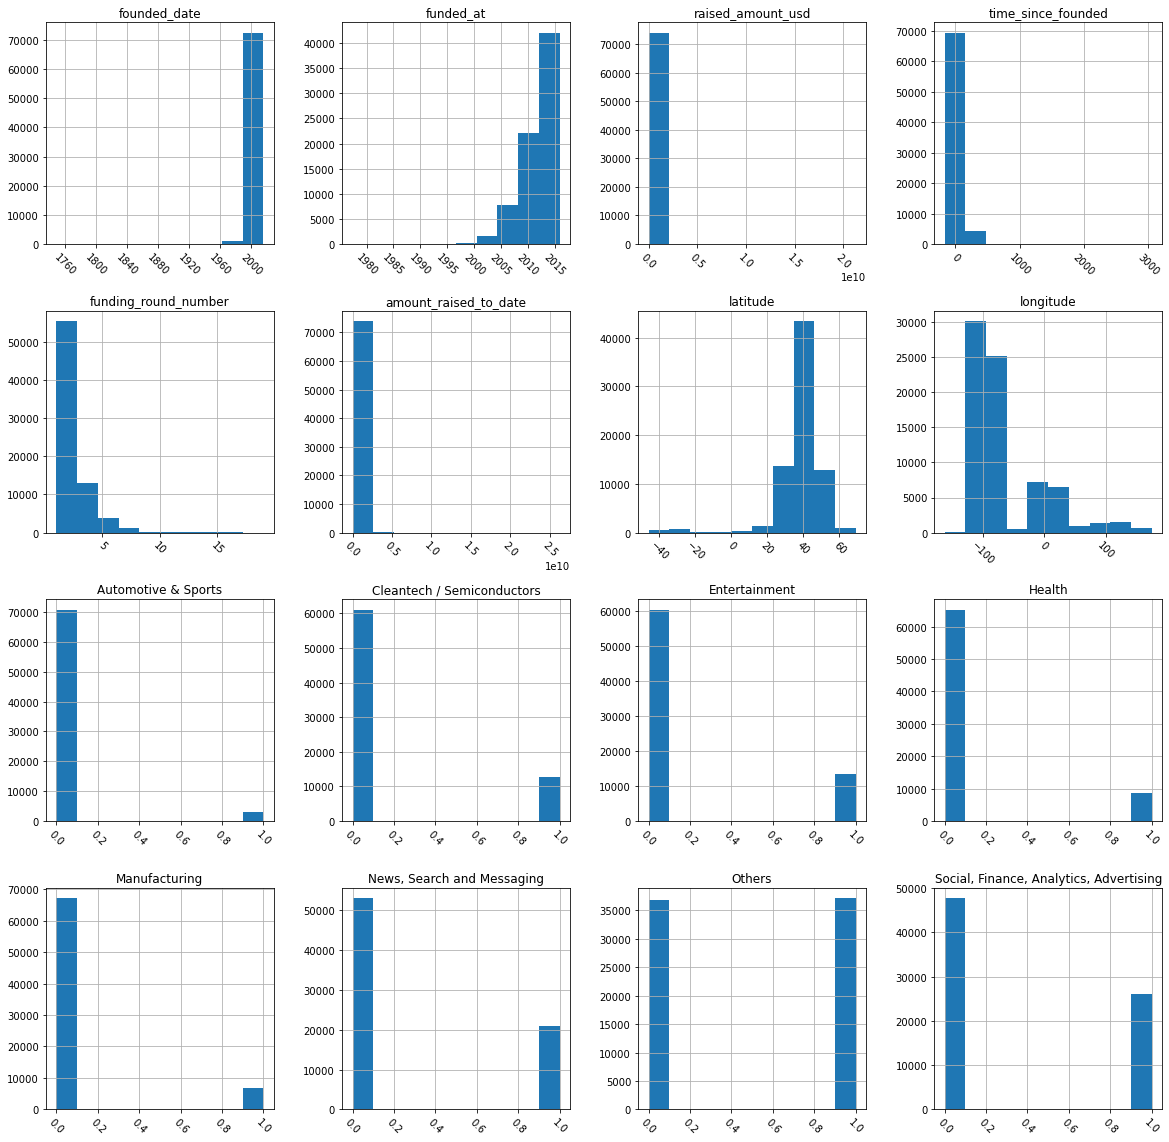

In [52]:
numerical_df = merged_df.select_dtypes(exclude='object')

# Histogram of plots
numerical_df.hist(figsize=(20,20), xrot=-45)
plt.show()

It is even more clear how there are extremities in the data from a violin plot of the raised amount. 

- The bulk of the data is hard to visualise properly as it is so skewed by the outliers.
- The mean and median are extremely far off one another
- The maximum is 20 billion dollars
- The standard deviation is very high

It will be hard to build a model with such extreme outliers, even if they are true values. It is also hard to properly visualise the bulk of the data, so they will be removed for the sake of modelling and visualisation. 

These will be removed once the categorical variables have been visualised.

If a report were to be made, a comment would need to be made to flag the values have been removed. 

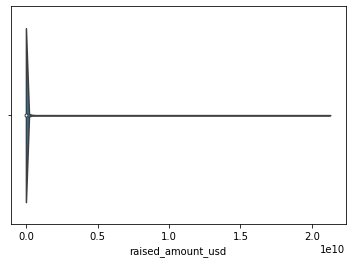

In [53]:
# See the distribution of amount raised
sns.violinplot(data=numerical_df, x='raised_amount_usd')
plt.show()

In [54]:
numerical_df.raised_amount_usd.describe()

count    7.391100e+04
mean     1.039015e+07
std      1.167945e+08
min      0.000000e+00
25%      3.621640e+05
50%      1.758258e+06
75%      7.000000e+06
max      2.127194e+10
Name: raised_amount_usd, dtype: float64

Correlations between each feature were plotted. There are very small correlations between each variable, particularly with raised_amount_usd which will make modelling more complex. They are likely not linearly related.

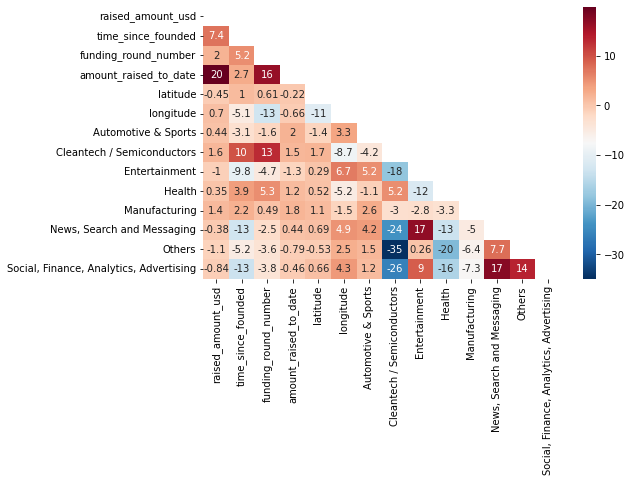

In [55]:
# Mask out the upper triangle
mask = np.zeros_like(numerical_df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(numerical_df.corr()*100, 
            cmap='RdBu_r', 
            annot = True, 
            mask = mask)
plt.show()

## Categorical Features

In [56]:
categorical_df = merged_df.select_dtypes('object')
categorical_df.columns

Index(['city', 'continent', 'country_name', 'funding_round_permalink',
       'funding_round_type', 'name', 'permalink', 'status', 'main_sector'],
      dtype='object')

Start by viewing the classes of categorical variables, then clean up the classes a bit based on visualisations and merge classes with few observations.

### Plot Count of each Variable

The number of times each class in each categorical variable appeared was printed. This helped identify which classes could be grouped. 
- The majority of funding rounds happened in North America
- Most investment rounds are venture, followed by seed. There are very few instances of funding rounds from lower down the graph
- There is a more fair spread of funding rounds in each industry

Classes with fewer observations and with similar properties can be grouped. 

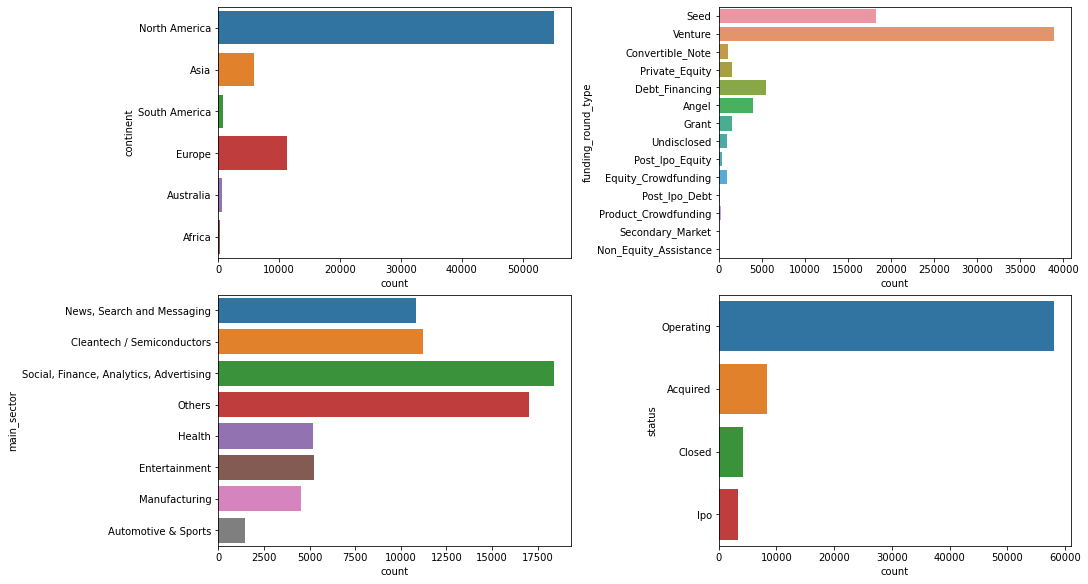

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(15,8), constrained_layout=True)

sns.countplot(ax=ax[0,0], y='continent', data=categorical_df)
sns.countplot(ax=ax[0,1], y='funding_round_type', data=categorical_df)
sns.countplot(ax=ax[1,0], y='main_sector', data=categorical_df)
sns.countplot(ax=ax[1,1], y='status', data=categorical_df)
plt.show()

## Segmentations

View the spread of the classes in each category, to identify which can be grouped. It is even more clear now that outliers need to be removed, as the spread of data cannot be visualised with such extreme values. 

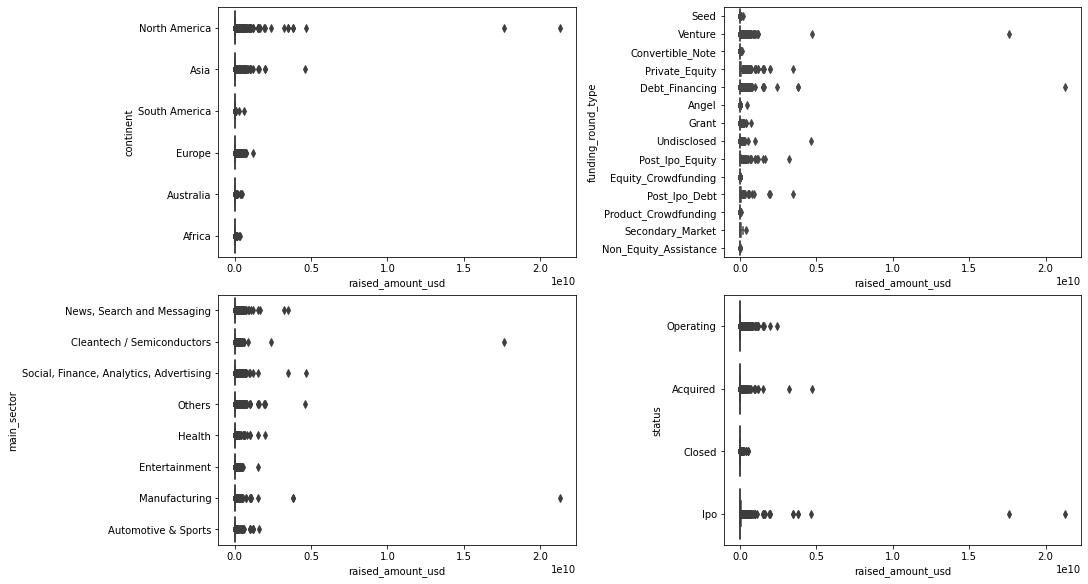

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(15,8), constrained_layout=True)

sns.boxplot(ax=ax[0,0], data=merged_df, x = 'raised_amount_usd', y = 'continent')
sns.boxplot(ax=ax[0,1], data=merged_df, x = 'raised_amount_usd', y = 'funding_round_type')
sns.boxplot(ax=ax[1,0], data=merged_df, x = 'raised_amount_usd', y = 'main_sector')
sns.boxplot(ax=ax[1,1], data=merged_df, x = 'raised_amount_usd', y = 'status')
plt.show()

## Removing Outliers

It is clear from visualising the numerical and categorical variables that the extreme values in the raised_amount_usd are having a huge impact on the bulk of the data. 

The acceptable range is 1.5 * the inter-quartile range. 

In [59]:
def drop_outliers(df, field_name):
    iqr = 1.5*(np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df = df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index)
    df = df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index)
    return df

filtered_df = drop_outliers(merged_df, 'raised_amount_usd')

The updated plots, violin and box, represent the spread of the data much better and insights can be taken from them. 

- The majority of investment amounts is focussed around 2.5m USD and below, and the maximum is now 17.5m USD, much more realistic (for successful companies later on in their funding)
- Private Equity, Venture and Post IPO Equity funding seem to get the largest investments
- Seed, Grant, Angel and early on investment rounds raise the smallest amount of money
- Companies which have been Acquired or are Post-IPO raise the most
- Cleantech / Semiconduscors seem to be the most attractive to investors

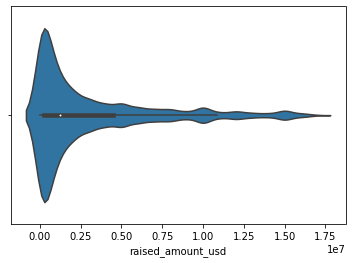

In [60]:
# See the distribution of amount raised
sns.violinplot(data=filtered_df, x='raised_amount_usd')
plt.show()

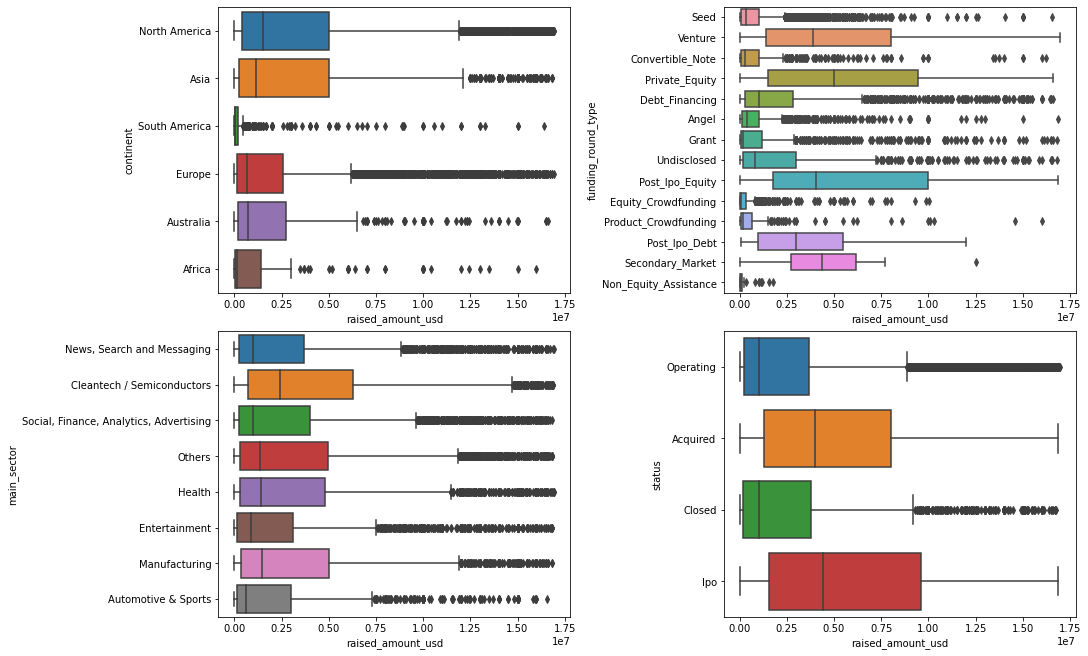

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(15,9), constrained_layout=True)

sns.boxplot(ax=ax[0,0], data=filtered_df, x = 'raised_amount_usd', y = 'continent')
sns.boxplot(ax=ax[0,1], data=filtered_df, x = 'raised_amount_usd', y = 'funding_round_type')
sns.boxplot(ax=ax[1,0], data=filtered_df, x = 'raised_amount_usd', y = 'main_sector')
sns.boxplot(ax=ax[1,1], data=filtered_df, x = 'raised_amount_usd', y = 'status')

plt.show()

## Merge Classes

### Funding Round Type

Website explaining types of fund: https://support.crunchbase.com/hc/en-us/articles/115010458467-Glossary-of-Funding-Types

Types of fund were researched and grouped into the following three categories. The main categories, such as venture, seed and anger, were kept the same. 

- Post IPO investments can be grouped: 
    - post_ipo_equity
    - post_ipo_debt
    - secondary_market
- Group non-equity funds:
    - grant
    - non_equity_assistance
- Group crowdfunding:
    - product_crowdfunding
    - equity_crowdfunding
    
Funding round code was brought back in as this could provide more insight into the spread of investments in venture funding rounds. In general, the further you get past A and B, the more you raise up until G and H. This could be because:
- The companies have gone through too many investment rounds which can bring doubt into investors minds as they wonder why they still need funding
- OR (more likely) there is not enough data for these rounds

<AxesSubplot:xlabel='raised_amount_usd', ylabel='funding_round_code'>

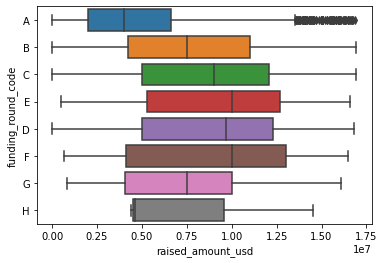

In [62]:
# Add funding round code back in
funding_code = pd.read_csv('merged_df_1.csv', sep=',', encoding='ISO-8859-1')
funding_code = funding_code[['funding_round_permalink', 'funding_round_code']]

# Merged dataset with funding round code
filtered_funding = pd.merge(filtered_df, funding_code, how='left', on='funding_round_permalink')
sns.boxplot(data=filtered_funding, x = 'raised_amount_usd', y = 'funding_round_code')

Let's see where we have most data points for the funding round codes.

As hoped, there are more for Venture funding rounds. However, there are much fewer values for rounds beyond C. These can be grouped into 'C+'.

As there are a lot of funding round codes missing for funding round types other than venture, these will not be combined. There are also less values which exist for these types anyway. 
- Funding round codes for non-venture funding will be set to blank
- Fudning round type and funding round code will be combined
- We have new categories:
    - Venture A
    - Venture B
    - Venture C+

In [63]:
filtered_funding[['funding_round_type', 'funding_round_code']].value_counts()

funding_round_type  funding_round_code
Venture             A                     9278
                    B                     4962
                    C                     2027
                    D                      752
                    E                      276
                    F                       85
Seed                A                       67
Venture             G                       22
Angel               A                       15
Seed                B                        8
Undisclosed         A                        3
Convertible_Note    A                        3
Venture             H                        3
Debt_Financing      B                        2
Convertible_Note    B                        2
Undisclosed         B                        1
Seed                C                        1
Post_Ipo_Equity     B                        1
Debt_Financing      D                        1
dtype: int64

In [64]:
# Replace any series after C with C+, as they are generally more established companies
filtered_funding['funding_round_code'] = filtered_funding['funding_round_code'].replace([
    'C', 'D', 'E', 'F', 'G', 'H'], 'C+') 

# Replace any funding round codes not in venture with NaN
filtered_funding['funding_round_code'] = filtered_funding['funding_round_code'].fillna('')
filtered_funding['funding_round_code'][filtered_funding['funding_round_type'] != 'Venture'] = ''

# Combine type of funding with funding round code and remove whitespace
filtered_funding['funding_round_type'] = filtered_funding['funding_round_type'] + ' ' + filtered_funding[
    'funding_round_code']
filtered_funding['funding_round_type'] = filtered_funding['funding_round_type'].str.rstrip()

Replace the funding round types with their new grouped name. 

In [65]:
# Replace column types
filtered_funding['funding_round_type'] = filtered_funding['funding_round_type'].replace([
    'Post_Ipo_Equity', 'Post_Ipo_Debt', 'Secondary_Market'], 'Post_IPO')

filtered_funding['funding_round_type'] = filtered_funding['funding_round_type'].replace([
    'Grant', 'Non_Equity_Assistance'], 'Non_Equity')

filtered_funding['funding_round_type'] = filtered_funding['funding_round_type'].replace([
    'Equity_Crowdfunding', 'Product_Crowdfunding'], 'Crowdfunding')

#### Visualise the new spread of funding rounds

Seed is now the main investment round, and there are more visible counts for the other rounds now. 

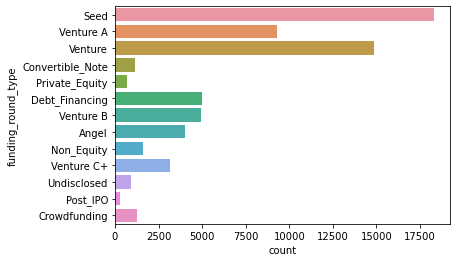

In [66]:
# See the spread of the data now
sns.countplot(y='funding_round_type', data=filtered_funding)
plt.show()

### Group Continent

Replace Africa, South America and Australia with 'Other'.

In [67]:
filtered_funding['continent'] = filtered_funding['continent'].replace([
    'Africa', 'South America', 'Australia'], 'Other')

# DataFrame Checkpoint

In [68]:
# Save csv file
filtered_funding.to_csv('220605_2125_filtered_funding.csv', sep=',', index=False)

# Data Visualisation

In [69]:
master_df = filtered_funding

## Exploring the Data

### The Spread of Companies Founded and Invested in over time

To see trends in the number of companies being founded and number of funding rounds happening throughout time. 

There are some obvious dips in companies being founded. These could be due to:
- **2008-2009**: The Housing Crisis
- **2003** Stock market crash and terrorism

There has also been a decrease in the more recent years. This could be as:
- Fewer companies are being founded due to people finding investments elsewhere, bitcoin, crypto currency etc., 
- Data has not been recorded for these years
- The database is out of date

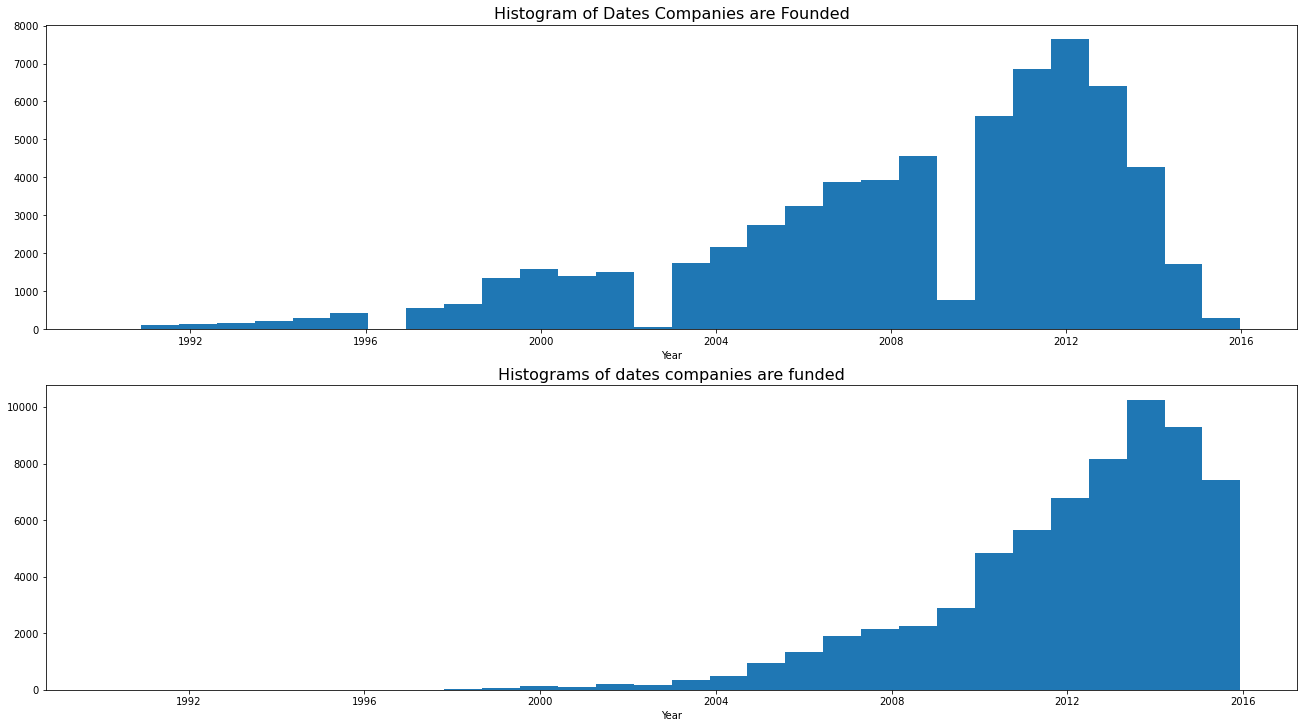

In [70]:
# Plot from 1990 onwards
founded_df = master_df['founded_date'][master_df['founded_date'] > '1990-01-01']
funded_df = master_df['funded_at'][master_df['funded_at'] > '1990-01-01']

fig, (ax1, ax2) = plt.subplots(2, figsize=(18,10), constrained_layout = True)
n_bins = 30
ax1.hist(founded_df, bins=n_bins)
ax1.set_xlabel('Year')
ax1.set_title('Histogram of Dates Companies are Founded', fontsize=16)

ax2.hist(funded_df, bins=n_bins)
ax2.set_xlabel('Year')
ax2.set_title('Histograms of dates companies are funded', fontsize=16)

plt.show()

### Spread of Investments

Now that the outliers have been removed, the mean and median are much closer. There us also a more clear trend in the spread of investments, with there being a much higher quantity of smaller funding rounds. This is expected as it is much harder to get more money. 

In [71]:
master_df['raised_amount_usd'].describe()

count    6.548400e+04
mean     3.069410e+06
std      3.930017e+06
min      0.000000e+00
25%      2.792250e+05
50%      1.250010e+06
75%      4.500000e+06
max      1.694444e+07
Name: raised_amount_usd, dtype: float64

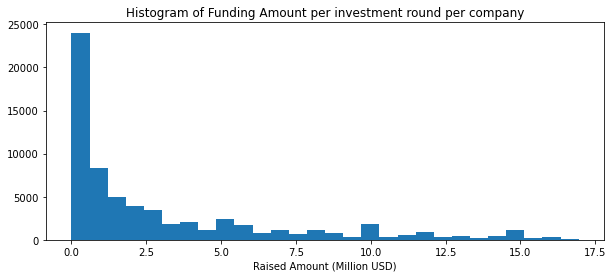

In [72]:
plt.figure(figsize=(10,4))
n_bins = 28
plt.hist(master_df['raised_amount_usd']/1000000, bins=n_bins)
plt.xlabel('Raised Amount (Million USD)')
plt.title('Histogram of Funding Amount per investment round per company', fontsize=12)

plt.show()

## Analysis Questions

### 1. Identify the top sector investment wise (consider the number of investments and size of investment)

A dataframe was created to contain the statistical data of amount invested by sector. This contained:
- Total funding
- Number of funding rounds
- Average funding per funding round

In [73]:
# Create a new dataframe for stats by sector
q1_stats = pd.DataFrame(index=sectors)

# Add a column for the sum of investments
q1_stats['total_investment_usd'] = [master_df.loc[
    master_df[sector] == 1, 'raised_amount_usd'].sum() for sector in sectors]
q1_stats['number_of_investments'] = [int(master_df[sector].sum()) for sector in sectors]
q1_stats['average_investment_amount'] = q1_stats['total_investment_usd']/q1_stats['number_of_investments'] 

# Sort by average investment amount
q1_stats = q1_stats.sort_values(by=['average_investment_amount'], ascending=False)

In [74]:
q1_stats

,total_investment_usd,number_of_investments,average_investment_amount
Cleantech / Semiconductors,4.072941e+10,10252,3.972826e+06
Health,2.384579e+10,7384,3.229386e+06
Manufacturing,1.872808e+10,5912,3.167808e+06
Others,9.632008e+10,33623,2.864708e+06
"Social, Finance, Analytics, Advertising",6.239724e+10,23850,2.616237e+06
"News, Search and Messaging",4.915597e+10,19226,2.556744e+06
Entertainment,3.071189e+10,12468,2.463258e+06
Automotive & Sports,5.839930e+09,2798,2.087180e+06


The amount invested into each sector is obviously dependent on the number of companies in it, as shown in the graph below. Therefore, another graph was plotted to visualise the average investment per company by sector. 

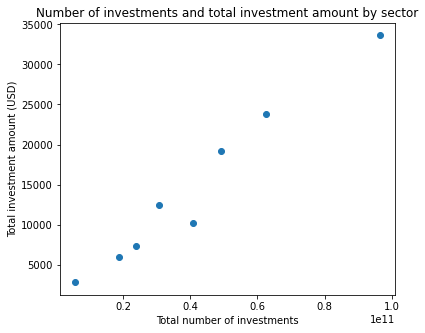

In [75]:
# Set the variables
total = q1_stats['total_investment_usd']
number = q1_stats['number_of_investments'] 
average = q1_stats['average_investment_amount']

# Create a plot
plt.figure(figsize=(6,5))
plt.xlabel('Total number of investments')
plt.ylabel('Total investment amount (USD)')
plt.title('Number of investments and total investment amount by sector')
plt.scatter(total, number)

plt.show()

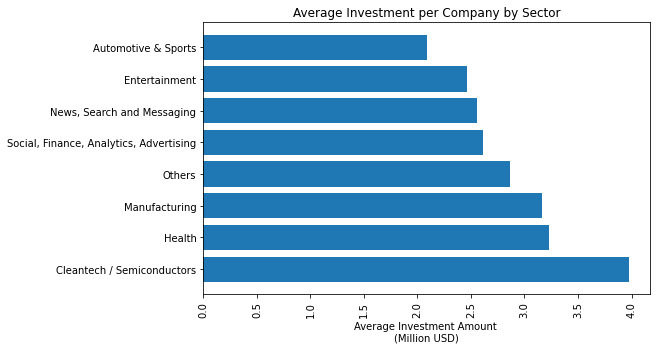

In [76]:
# Plot by average amount invested per company 
plt.figure(figsize=(8, 5))
plt.barh(q1_stats.index, q1_stats['average_investment_amount']/1000000)
plt.xticks(rotation=90)
plt.xlabel('Average Investment Amount \n(Million USD)')
plt.title('Average Investment per Company by Sector', fontsize=12)
plt.show()

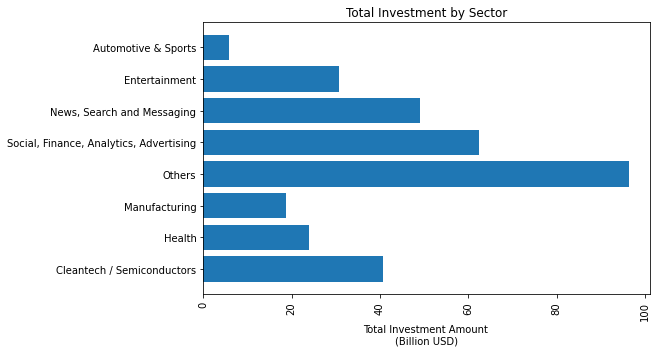

In [77]:
# Plot by total investment
plt.figure(figsize=(8, 5))
plt.barh(q1_stats.index, q1_stats['total_investment_usd']/1000000000)
plt.xticks(rotation=90)
plt.xlabel('Total Investment Amount \n(Billion USD)')
plt.title('Total Investment by Sector', fontsize=12)
plt.show()

### 2. In the top sector, which company received highest investment (total amount)

Tigo Energy raised around 85 million USD in total. Tigo Energy is a solar energy company so it's not surprising this has been very successful given the recent climate crisis. They might also be considered early adopters since they started funding in 2008.

In [78]:
top_sector = 'Cleantech / Semiconductors'
q2_df = master_df[master_df[top_sector] == 1][['permalink', 'name', 'raised_amount_usd']].groupby(
    by=['permalink', 'name']).sum()
top_5 = q2_df.sort_values(by='raised_amount_usd', ascending=False).head(5)
top_5

,,raised_amount_usd
permalink,name,
/organization/tigo-energy,tigo energy,85662749.0
/organization/irhythm,irhythm technologies,83678860.0
/organization/illumitex,illumitex,79835051.0
/organization/exagen-diagnostics,exagen diagnostics,79745088.0
/organization/avnera,avnera,77447377.0


In [79]:
# Save the names of the top invested companies
top_companies = top_5.reset_index()
top_companies = top_companies['permalink'].tolist()

# Get the list of all the funding rounds of the top companies
top = master_df[['permalink', 'funding_round_type', 'raised_amount_usd', 'funded_at']][
    master_df['permalink'] == '/organization/tigo-energy']

top.sort_values(by=['permalink', 'funded_at'])

,permalink,funding_round_type,raised_amount_usd,funded_at
57423,/organization/tigo-energy,Venture A,6000000.0,2008-05-23
57418,/organization/tigo-energy,Venture A,1661116.0,2009-01-06
57411,/organization/tigo-energy,Venture B,10000000.0,2009-08-06
57420,/organization/tigo-energy,Venture C+,10144000.0,2010-05-28
57424,/organization/tigo-energy,Convertible_Note,475000.0,2011-01-21
57417,/organization/tigo-energy,Venture C+,5000000.0,2011-02-11
57414,/organization/tigo-energy,Venture C+,10000000.0,2011-11-04
57425,/organization/tigo-energy,Debt_Financing,2950000.0,2012-08-30
57416,/organization/tigo-energy,Venture,13112463.0,2013-09-05
57415,/organization/tigo-energy,Venture,6500000.0,2014-02-28


### 3. Find the trends, for example investment trends in Americas vs Europe vs Asia or fund types. (Use your imagination)

# Trends 

## By Continent

### Main Sector in each Continent based on Amount Invested

In [80]:
# Create a table with the mean, number of companies 
by_continent = master_df.groupby(by=['continent', 'main_sector']).raised_amount_usd.agg(['count', 'mean', 'sum'])
by_world = master_df.groupby(by=['main_sector']).raised_amount_usd.agg(['count', 'mean', 'sum'])

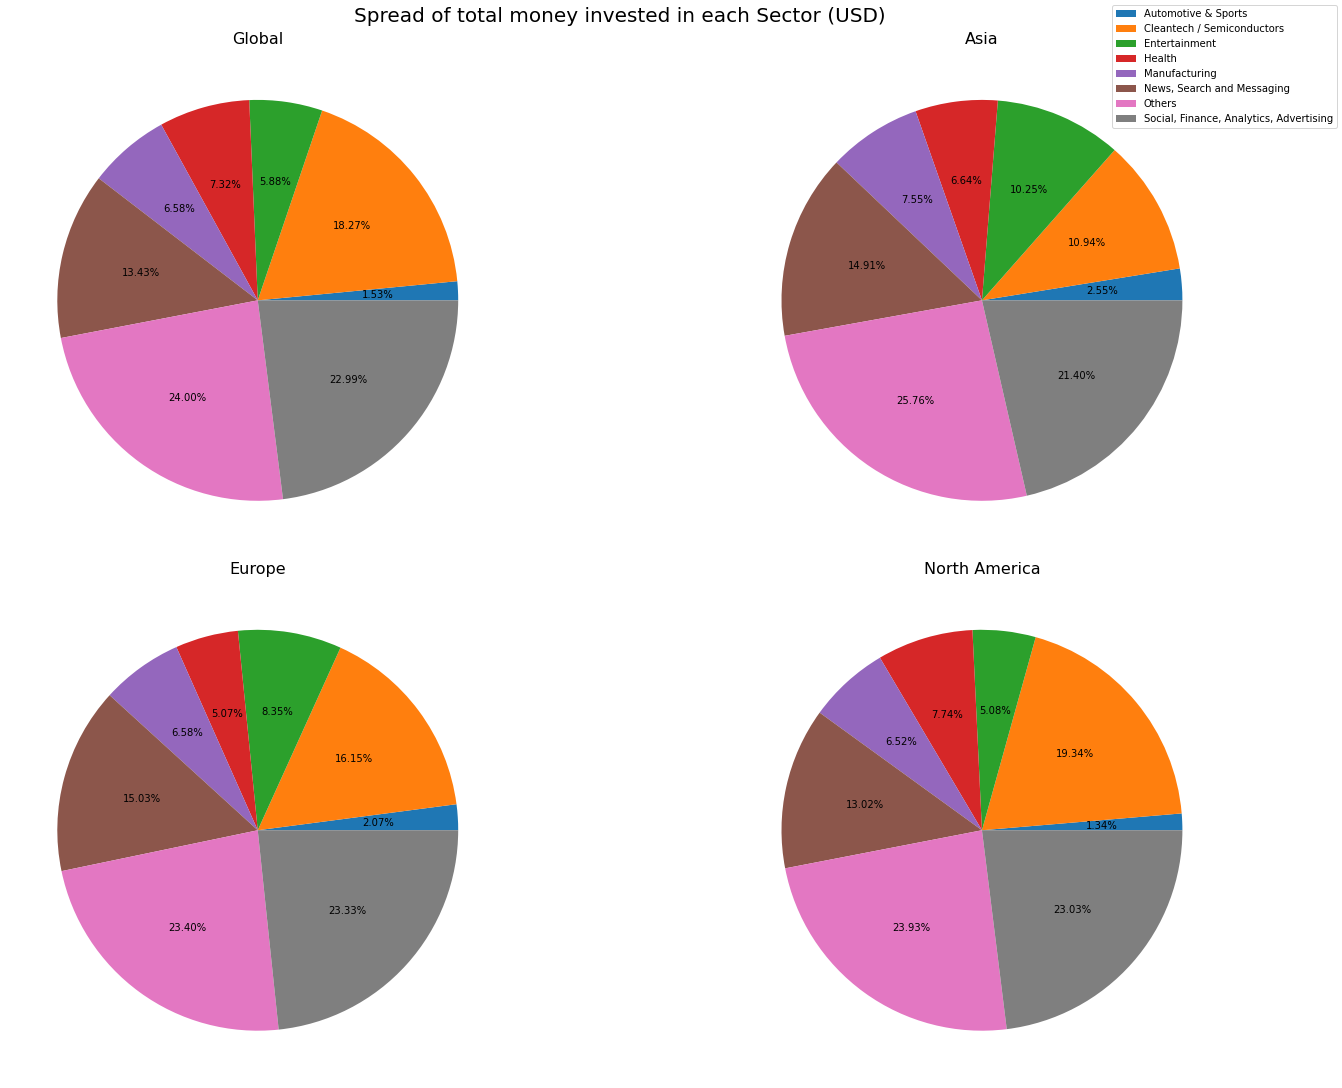

In [81]:
# Pie chart of investments per sector
fig, ax = plt.subplots(2,2, figsize=(20,15), constrained_layout=True)
fig.suptitle('Spread of total money invested in each Sector (USD)', fontsize=20)

# Get continent tables
by_continent = by_continent.reset_index()
asia = by_continent[by_continent['continent'] == 'Asia']
europe = by_continent[by_continent['continent'] == 'Europe']
usa = by_continent[by_continent['continent'] == 'North America']

# Plot investment amount from each industry
labels = asia['main_sector']
ax[0,0].pie(by_world['sum'], startangle=0, autopct='%1.2f%%')
ax[0,0].set_title('Global', fontsize=16)

ax[0,1].pie(asia['sum'], startangle=0, autopct='%1.2f%%')
ax[0,1].set_title('Asia', fontsize=16)

ax[1,0].pie(europe['sum'], startangle=0, autopct='%1.2f%%')
ax[1,0].set_title('Europe', fontsize=16)

ax[1,1].pie(usa['sum'], startangle=0, autopct='%1.2f%%')
ax[1,1].set_title('North America', fontsize=16)

fig.legend(labels)

plt.show()

If Others is excluded (as it will contain a combination of other smaller sectors) then the main sector in terms of amount invested into it for each continent is Social, Finance, Analytics and Advertising. 

However, as said before this is skewed because it could just be because there are a lot of companies in that sector that have been recorded in the database. Let's visualise this based on the number of companies in the sector. 

### Number of Companies in each Sector

In [82]:
# Column for the number of companies in each industry in each continent
company_count = master_df.groupby(by=['continent', 'main_sector', 'permalink']).permalink.agg(['count'])
company_count = company_count.reset_index()
company_count = company_count.groupby(by=['continent', 'main_sector']).permalink.agg(['count'])

by_continent = pd.merge(by_continent, company_count, how='left', on=['continent', 'main_sector'])

In [83]:
# Rename column names
by_continent = by_continent.rename(columns={'count_x':'funding_round_count', 'count_y':'number_of_companies'})

# Number of companies in each sector worldwide
world_company_count = master_df.groupby(by=['main_sector', 'permalink']).permalink.agg(['count'])
world_company_count = world_company_count.reset_index()
world_company_count = world_company_count.groupby(by=['main_sector']).permalink.agg(['count'])

by_world = pd.merge(by_world, world_company_count, how='left', on=['main_sector'])
by_world = by_world.rename(columns={'count_x':'funding_round_count', 'count_y':'number_of_companies'})

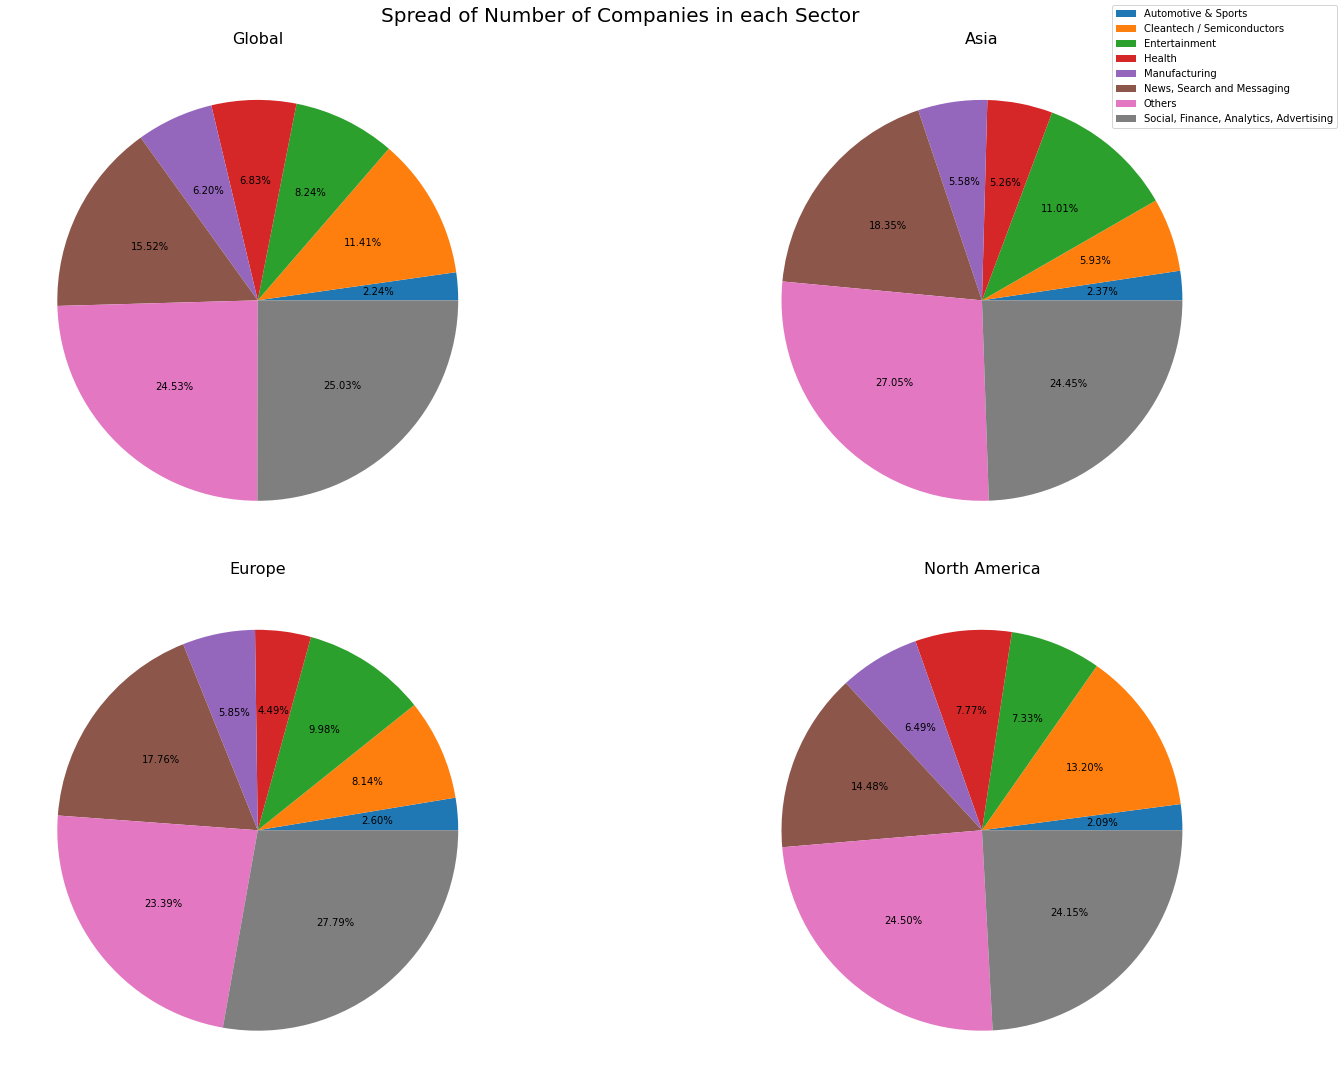

In [84]:
# Pie chart of companies per sector
fig, ax = plt.subplots(2,2, figsize=(20,15), constrained_layout=True)
fig.suptitle('Spread of Number of Companies in each Sector', fontsize=20)

# Get continent tables
by_continent = by_continent.reset_index()
asia = by_continent[by_continent['continent'] == 'Asia']
europe = by_continent[by_continent['continent'] == 'Europe']
usa = by_continent[by_continent['continent'] == 'North America']

# Plot investment amount from each industry
labels = asia['main_sector']
ax[0,0].pie(by_world['number_of_companies'], startangle=0, autopct='%1.2f%%')
ax[0,0].set_title('Global', fontsize=16)

ax[0,1].pie(asia['number_of_companies'], startangle=0, autopct='%1.2f%%')
ax[0,1].set_title('Asia', fontsize=16)

ax[1,0].pie(europe['number_of_companies'], startangle=0, autopct='%1.2f%%')
ax[1,0].set_title('Europe', fontsize=16)

ax[1,1].pie(usa['number_of_companies'], startangle=0, autopct='%1.2f%%')
ax[1,1].set_title('North America', fontsize=16)

fig.legend(labels)

plt.show()

As expected, there are most companies in the biggest earning sectors. However, what's more noticable is that the number of companies in the Semiconductors / Cleantech space is much smaller than the % income it provides for that continent and globally. 

### Average Income Per Company in the Sectors

In [85]:
# Calaulate mean by company
by_continent['mean_by_company'] = by_continent['sum']/by_continent['number_of_companies']
by_world['mean_by_company'] = by_world['sum']/by_world['number_of_companies']

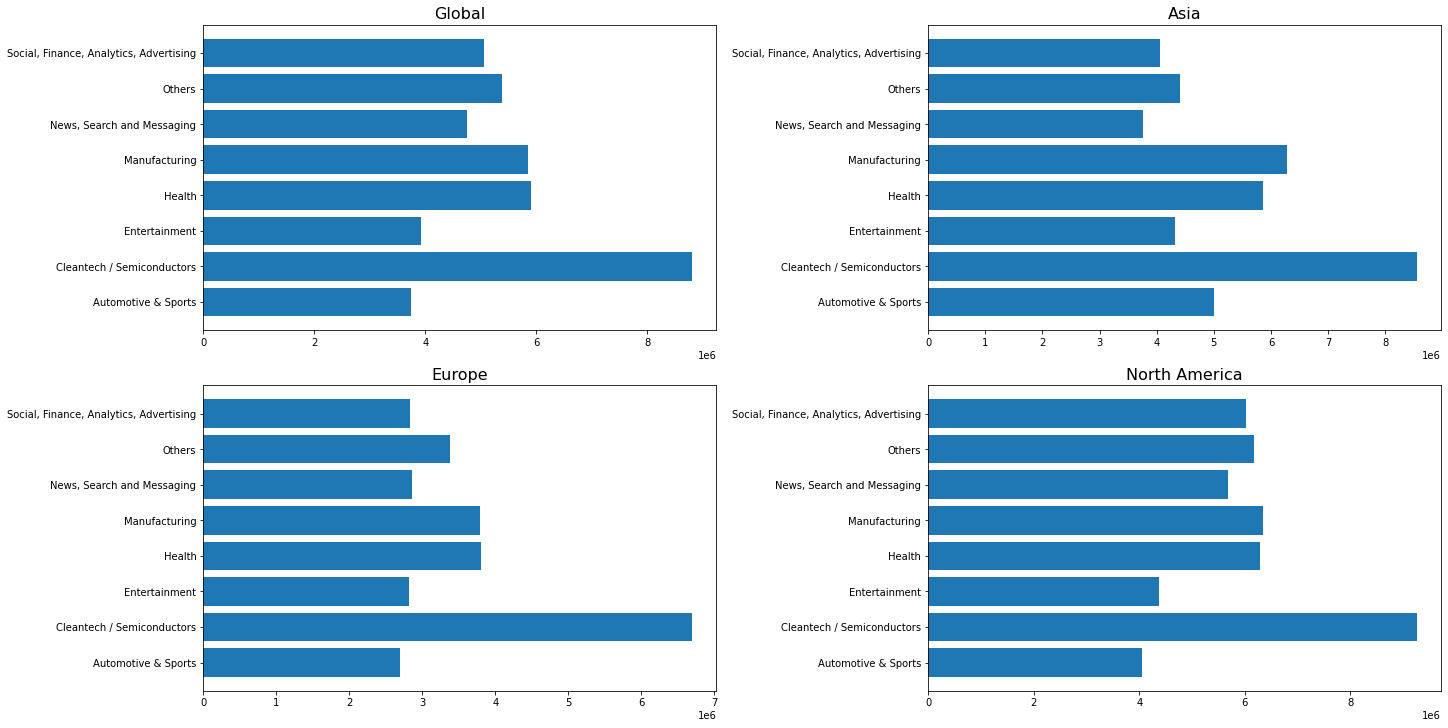

In [86]:
ig, ax = plt.subplots(2,2, figsize=(20,10), constrained_layout=True)
fig.suptitle('Spread of Number of Companies in each Sector', fontsize=20)

# Get continent tables
# by_continent = by_continent.reset_index()
asia = by_continent[by_continent['continent'] == 'Asia']
europe = by_continent[by_continent['continent'] == 'Europe']
usa = by_continent[by_continent['continent'] == 'North America']

# Plot investment amount from each industry
labels = asia['main_sector']
ax[0,0].barh(labels, by_world['mean_by_company'])
ax[0,0].set_title('Global', fontsize=16)

ax[0,1].barh(labels, asia['mean_by_company'])
ax[0,1].set_title('Asia', fontsize=16)

ax[1,0].barh(labels, europe['mean_by_company'])
ax[1,0].set_title('Europe', fontsize=16)

ax[1,1].barh(labels, usa['mean_by_company'])
ax[1,1].set_title('North America', fontsize=16)

fig.legend(labels)

plt.show()

- The average funding per company is highest for Cleantech / Semiconductors, as expected based on the small number of companies compared to total amount invested in the sector. 
- Automotive & sports is much smaller in Europe and North America compared to Asia
- Manufacturing is large in all
- Entertainment seems to be a consistenly low funded sector in all continents
- Social, Finance, Analytics and Advertising is much larger in North America compared to other continents

## By Sector

### Number of Companies being Founded in each Sector by Year

This will help visualise which sectors have become more/less popular over time based on the number of companies being founded. 

In [87]:
founded_by = master_df[['main_sector', 'founded_date', 'permalink']]
founded_by['founded_date'] = pd.DatetimeIndex(founded_by['founded_date']).year

founded_by = founded_by.groupby(['main_sector', 'founded_date', 'permalink']).permalink.agg(['count'])
founded_by = founded_by.reset_index()
founded_by = founded_by.groupby(['main_sector', 'founded_date']).permalink.agg(['count'])

# Create a pivot table to plot more easily
founded_by = pd.pivot_table(founded_by, values='count', columns='main_sector', index='founded_date')

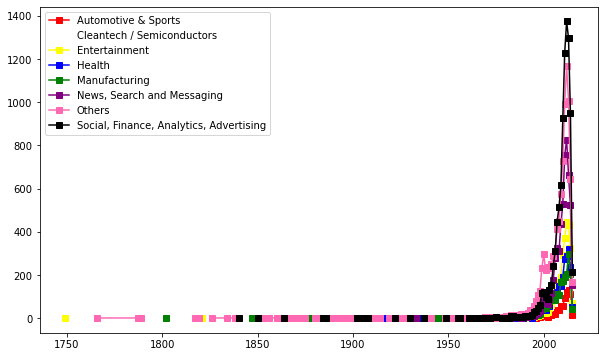

In [88]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

color_dict = {'Automotive & Sports': 'red', 'Cleantech / Semiconductors': 'white', 'Entertainment': 'yellow',
              'Health': 'blue', 'Manufacturing': 'green', 'News, Search and Messaging': 'purple', 
              'Others': '#ff69b4', 'Social, Finance, Analytics, Advertising': 'black'}

for column in founded_by.columns:
    ax1.plot(founded_by.index, founded_by[column], c=color_dict[column], marker="s", label=column)

plt.legend(loc='upper left')
plt.show()

There seen to be some outliers in the year the companies were founded as it is skewed a lot to the right. Therefore these outliers will be removed in the same way they were for the amount raised in USD. 

### Remove outliers in year founded

In [89]:
def drop_outliers(df, field_name):
    iqr = 1.5*(np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df = df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index)
    df = df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index)
    return df

master_year_filtered = drop_outliers(master_df, 'founded_date')

- The median is much closer to the mean which shows outliers have been removed
- The 75th percentile is very close to the maximum year, which shows it's likely more companies were founded much later on

In [90]:
master_year_filtered['founded_date'] = pd.DatetimeIndex(master_year_filtered['founded_date']).year

In [91]:
master_year_filtered['founded_date'].describe()

count    62937.000000
mean      2008.646408
std          4.268145
min       1996.000000
25%       2006.000000
50%       2010.000000
75%       2012.000000
max       2015.000000
Name: founded_date, dtype: float64

In [92]:
filtered_founded_by = master_year_filtered[['main_sector', 'founded_date', 'permalink']]

filtered_founded_by = filtered_founded_by.groupby(['main_sector', 'founded_date', 'permalink']).permalink.agg(
    ['count'])
filtered_founded_by = filtered_founded_by.reset_index()
filtered_founded_by = filtered_founded_by.groupby(['main_sector', 'founded_date']).permalink.agg(['count'])

# Create a pivot table to plot more easily
filtered_founded_by = pd.pivot_table(filtered_founded_by, values='count', columns='main_sector', index='founded_date')

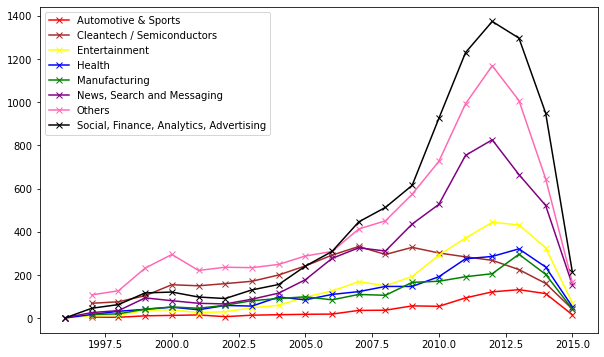

In [93]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

color_dict = {'Automotive & Sports': 'red', 'Cleantech / Semiconductors': 'brown', 'Entertainment': 'yellow',
              'Health': 'blue', 'Manufacturing': 'green', 'News, Search and Messaging': 'purple', 
              'Others': '#ff69b4', 'Social, Finance, Analytics, Advertising': 'black'}

for column in founded_by.columns:
    ax1.plot(filtered_founded_by.index, filtered_founded_by[column], c=color_dict[column], marker="x", label=column)

plt.legend(loc='upper left')
plt.show()

All sectors have seen a peak in companies founded around 2012, then have decreased a lot leading up to 2015. 
Social, Finance, Analytics and Advertising is the fastest growing sector
- Automotive & Sports has remained the most consistent. 
- News, Search and Messaging has also seen an increase (likely with the rise of social media and smartphone technology)
- Entertainment has also increased a lot, again this is likely due to the rise in technology

### Total investment into each sector by year

In [98]:
master_year_filtered['founded_date'].describe()

count    62937.000000
mean      2008.646408
std          4.268145
min       1996.000000
25%       2006.000000
50%       2010.000000
75%       2012.000000
max       2015.000000
Name: founded_date, dtype: float64

In [99]:
invested_by = master_year_filtered
invested_by = invested_by.groupby(['main_sector', 'founded_date']).raised_amount_usd.agg(['sum', 'mean'])
invested_by = invested_by.reset_index()
invested_by_mean = pd.pivot_table(invested_by, values='mean', columns='main_sector', index='founded_date')
invested_by_sum = pd.pivot_table(invested_by, values='sum', columns='main_sector', index='founded_date')

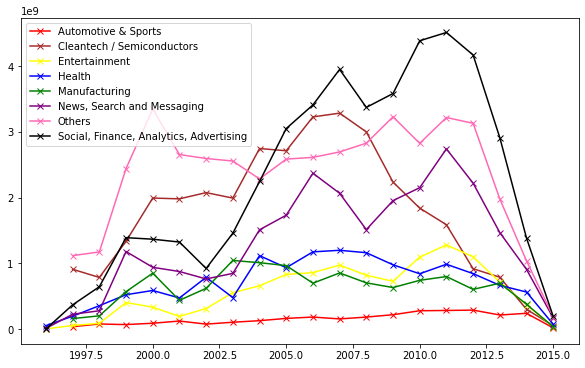

In [100]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

color_dict = {'Automotive & Sports': 'red', 'Cleantech / Semiconductors': 'brown', 'Entertainment': 'yellow',
              'Health': 'blue', 'Manufacturing': 'green', 'News, Search and Messaging': 'purple', 
              'Others': '#ff69b4', 'Social, Finance, Analytics, Advertising': 'black'}

for column in invested_by_sum.columns:
    ax1.plot(invested_by_sum.index, invested_by_sum[column], c=color_dict[column], marker="x", label=column)

plt.legend(loc='upper left')
plt.show()

Similar trends are seen here as above.
- Automotive & Sports remains the most consistent
- All sectors saw a dip around 2008, this could be due to the housing crisis
- Most sectors peaked in 2012 and have decreased since then

### Average investment per company by year

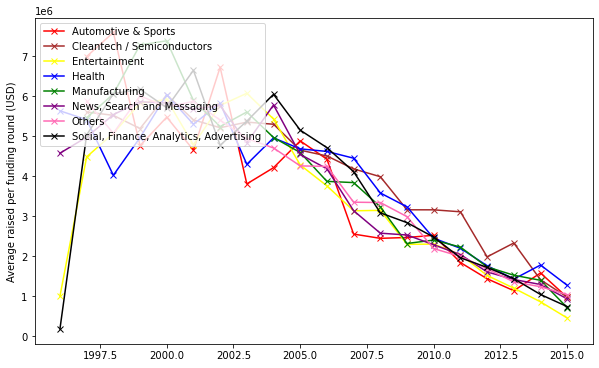

In [102]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

for column in invested_by_mean.columns:
    ax1.plot(invested_by_mean.index, invested_by_mean[column], c=color_dict[column], marker="x", 
             label=column)
    plt.ylabel('Average raised per funding round (USD)')
    
plt.legend(loc='upper left')
plt.show()

Investment per company has been decreasing with time, despite the total increase in the sector funding. 

This means that while funding amount has been growing, the number of companies joining the sector has been growing faster. Therefore there is more competition and either less companies are successful or they just get less funding. 

In [104]:
master_df = master_year_filtered

## By Funding Type

- As expected, Venture, provate-equity and Post-IPO funding rounds receive the highest average funding
- Early stage investment rounds are more heavily biased towards lower level investments, including angel, grant, seet and crowdfunding
- The amount invested in venture rounds increases the the number they go through, with C+ raising the most per funding round

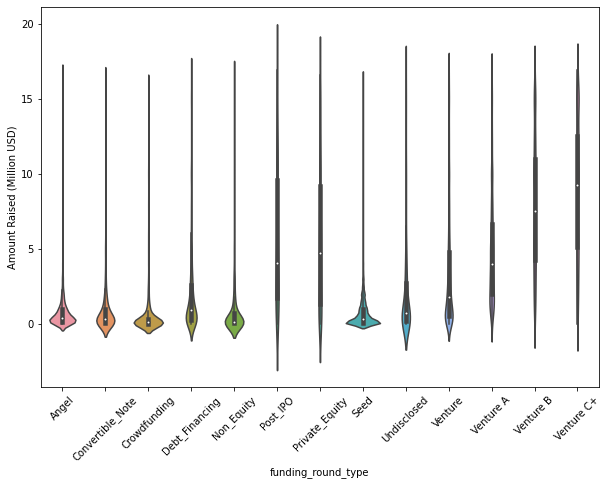

In [105]:
by_fund = master_df.groupby(['funding_round_type']).raised_amount_usd.agg(['sum', 'count', 'mean'])

sorted_funds = master_df.sort_values(by='funding_round_type')
fund = sorted_funds['funding_round_type']
raised = sorted_funds['raised_amount_usd']

fig, ax = plt.subplots(figsize=(10,7))
sns.violinplot(x=fund, y=raised/1000000)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Amount Raised (Million USD)')

plt.show()

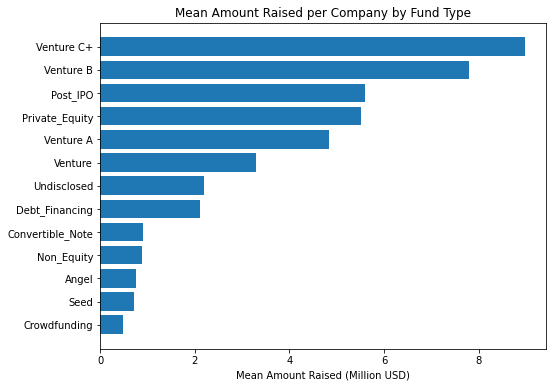

In [106]:
by_fund = by_fund.sort_values(by='mean')
plt.figure(figsize=(8,6))
plt.barh(by_fund.index, by_fund['mean']/1000000)
plt.xlabel('Mean Amount Raised (Million USD)')
plt.title('Mean Amount Raised per Company by Fund Type')

plt.show()

- Venture rounds raise the most
- Early stage and crowdfunding rounds raise the least

### Success rate of funding rounds

This was shown out of interest, but most rounds included in the database were successful rounds. Crowdfunding had the lowest success rate but also had the fewest data points to go off so might be less reliable. 

In [107]:
# Success of investment round types
success_df = master_df
success_df['success'] = ''
success_df['success'].loc[success_df['raised_amount_usd'] > 0] = 1
success_df['success'].loc[success_df['raised_amount_usd'] == 0] = 0
by_fund['success'] = success_df.groupby(['funding_round_type']).success.agg(['sum'])

In [108]:
# Calculate % success of each round
by_fund['percent_success'] = by_fund['success']*100/by_fund['count']
by_fund

,sum,count,mean,success,percent_success
funding_round_type,,,,,
Crowdfunding,6.164758e+08,1264,4.877182e+05,1093,86.471519
Seed,1.311359e+10,18155,7.223127e+05,18089,99.636464
Angel,3.036379e+09,3987,7.615698e+05,3962,99.372962
Non_Equity,1.234205e+09,1393,8.860049e+05,1388,99.641062
Convertible_Note,9.962188e+08,1110,8.974944e+05,1090,98.198198
Debt_Financing,9.949863e+09,4713,2.111153e+06,4692,99.554424
Undisclosed,1.886377e+09,863,2.185836e+06,850,98.493627
Venture,4.513323e+10,13697,3.295118e+06,13684,99.905089
Venture A,4.391320e+10,9096,4.827748e+06,9093,99.967018


### Amount Raised per Country

In [109]:
country_df = merged_df.groupby(['country_name']).raised_amount_usd.agg(['sum', 'count', 'mean'])
country_df = country_df.sort_values(by='sum', ascending=False)

In [110]:
country_df

,sum,count,mean
country_name,,,
United States,5.714699e+11,53079,1.076640e+07
China,5.635108e+10,1155,4.878882e+07
United Kingdom,2.528225e+10,4075,6.204233e+06
India,2.401325e+10,1406,1.707913e+07
Canada,1.195520e+10,1866,6.406858e+06
...,...,...,...
Uzbekistan,9.000000e+04,1,9.000000e+04
North Macedonia,3.848400e+04,1,3.848400e+04
Seychelles,3.500000e+04,1,3.500000e+04


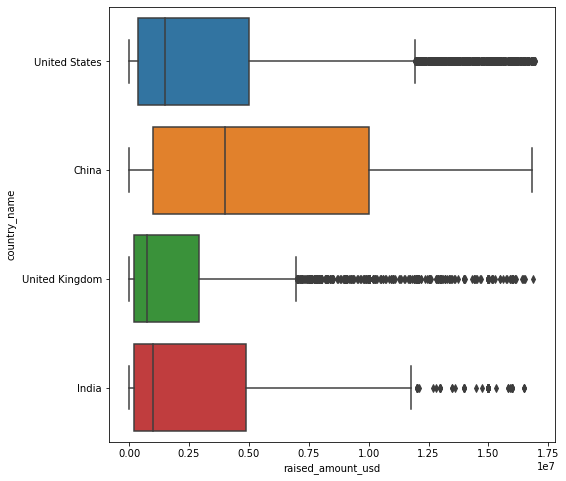

In [111]:
# Select the top 5 countries by sum invested
df = master_df[master_df['country_name'].isin(country_df.index[:4])]

# Box plot by country
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(x='raised_amount_usd', y='country_name', data=df)

plt.show()

## Q4: Use this dataset to build a model that predicts raised_amount_usd. Clearly show your approach and how you measure the performance of your model.

In [112]:
master_df.to_csv("220605_2125_master_df.csv", sep=',', index=False)




## Appendix: Additional Cleaning

Not used in the end but used as a first attempt at reducing features when the first model didn't perform well. 

### Filter by Funding Round Type

In [ ]:
merged_df['funding_round_type'].value_counts()

#### Types of funding round:
- **Venture:** A form of private equity financing provided by venture capital firms or funds to startups, early-stage and emerging companies that have been deemed to have high growth potential or which have demonstrated high growth
- **Seed:** The first official equity funding stage. Typically represents the first official money that a business venture or enterprise raises.
- **Debt Financing:** A way for cbusiness to raise capital through means of borrowing.
- **Angel:** An individual who provides capital for a business or businesses startup, usually in exchange for convertible debt or ownership equity. 
- **Grant:** A fund given by an end entity grant, often a public body, charitable foundation or a specialised grant-making institution, to an individual or another entity for a specific purpose linked to public benefit.
- **Private Equity:** An alternative investment class and consists of capital that is not listed on a public exchange. Composed of funds and investors that directly invest in private companies, or that engage in buyouts of public companies, resulting in the delisting of private equity.
- **Convertible Note:** A form of short term debt that converts into equity, typically in a later financing round. The financer basically loans money to a startup and instead of a return in the form of principal plus interest, the investor would receive equity in the company.
- **Equity crowdfunding:** Where people invest in an early stage unlisted company in exchange for shares in that company. A shareholder has partial ownership of a company.
- **Undisclosed:** undisclosed
- **Post IPO Equity:** Takes place when firms invest in a company after the company has already gone public.
- **Product Crowdfunding:** Raising money for a product through a large number of people, in return for a product.
- **Post IPO Debt:** A transaction when corporatrs loan a company money after the company has already gone public
- **Non Equity Assistance:** When a company or investor provides office space or mentorship and does not get equity in return.
- **Secondary Market:** Where investors buy and sell securities they already own.

### Find Trends with type of investmemt

In [ ]:
merged_df['funding_round_type'].value_counts()

In [ ]:
y = merged_df['raised_amount_usd']
x1 = merged_df['funded_at']
color = merged_df['funding_round_type']

fig, ax = plt.subplots(figsize=(10,8))
colors = {'Venture':'tab:blue', 'Seed':'tab:orange', 'Debt_Financing':'tab:green', 'Angel':'tab:red', 'Grant':'tab:purple', 'Private_Equity':'tab:brown', 'Convertible_Note':'tab:pink', 'Equity_Crowdfunding':'xkcd:yellow', 'Undisclosed':'xkcd:light pink', 'Post_Ipo_Equity':'xkcd:grey', 'Product_Crowdfunding':'xkcd:dark blue', 'Post_Ipo_Debt':'xkcd:green yellow', 'Non_Equity_Assistance':'xkcd:dark turquoise', 'Secondary_Market':'xkcd:salmon'}  

ax.scatter(x1, y, c=color.map(colors))

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
# Find the companies which raised over £700m
merged_df[merged_df['raised_amount_usd'] > 700000000][['country_name', 'founded_date', 'funded_at', 'funding_round_type', 'name', 'raised_amount_usd']].head(25)

In [ ]:
raised_filtered = merged_df[merged_df['raised_amount_usd'] < 700000000]

y = raised_filtered['raised_amount_usd']
x1 = raised_filtered['funded_at']
x2 = raised_filtered['founded_date']
color = raised_filtered['funding_round_type']

fig, ax = plt.subplots(2, 1, figsize=(15,10))
colors = {'Venture':'tab:blue', 'Seed':'tab:orange', 'Debt_Financing':'tab:green', 'Angel':'tab:red', 'Grant':'tab:purple', 'Private_Equity':'tab:brown', 'Convertible_Note':'tab:pink', 'Equity_Crowdfunding':'xkcd:yellow', 'Undisclosed':'xkcd:light pink', 'Post_Ipo_Equity':'xkcd:grey', 'Product_Crowdfunding':'xkcd:dark blue', 'Post_Ipo_Debt':'xkcd:green yellow', 'Non_Equity_Assistance':'xkcd:dark turquoise', 'Secondary_Market':'xkcd:salmon'}  

ax[0].scatter(x1, y, c=color.map(colors))
ax[0].set_title('x = year invested')

ax[1].scatter(x2, y, c=color.map(colors))
ax[1].set_title('x = year founded')


handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
fig.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x=fund, y=raised/1000000)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Amount Raised (Million USD)')

plt.show()